In [9]:
import pandas as pd 
import numpy as np
import seaborn as sns

In [10]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import the dataset that we have constructed and we encoded the variables. Then, we check for correlated variables.

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [11]:
dataset_original = pd.read_csv(r'Definitive_ML_Data.csv', index_col = 0)
dataset_original = dataset_original.dropna()
dataset = dataset_original.copy()

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_variables = ["season", "team", "Away_team", "result_home"]

for col in categorical_variables:
    dataset[f"{col}_encoded"] = le.fit_transform(dataset[col])
    
dataset = dataset.drop(categorical_variables, axis=1)

In [13]:
# Cheking for features too correlated
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

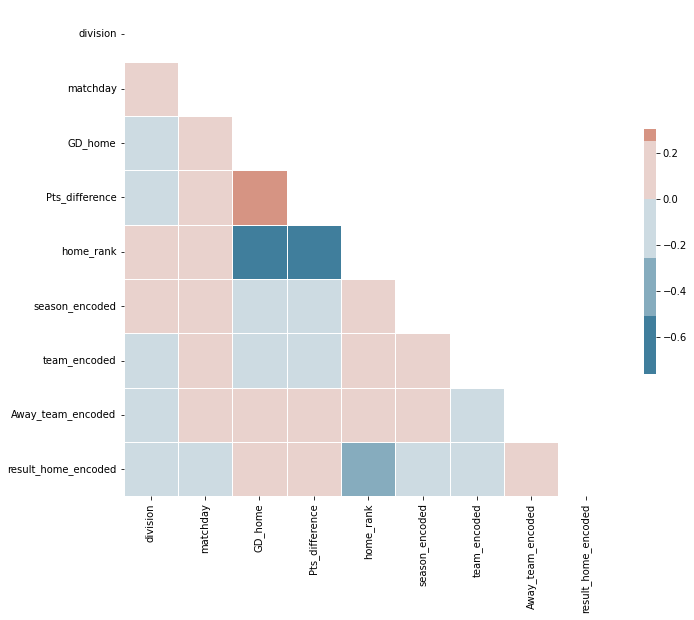

In [14]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Splitting data

In [15]:
target = dataset.result_home_encoded
X = dataset.loc[:, dataset.columns != 'result_home_encoded']
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.2, random_state=1, stratify=target)

## Function to construct Confusion matrix and ROC

In [16]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

We have decided to use the next models: **Logistic Regression**, **Decision Tree** and **Random Forest**. In order to obtain better performance we decided to do a search for the parameters that produce better performance on each model.

### Logistic Regression Analysis
For the **Logistic Regression** we can set different values for the parameter *C*, this one correspond to a L2 regularization parameter, the higher is the more regularization is applied.
A useful point of view of the parameter is that when takes a high value it tries to fit the training data as much as possible and for low values the models puts more emphasis to adjust the "majority" of the data points.

In [17]:
# Looking for best parameter for logistic regression model
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Accuracy_training_logreg = [] * len(C_values)
Accuracy_test_logreg = [] * len(C_values)
for C in C_values:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_f1_in = f1_score(y_train, prediction_in, average="weighted")
    prediction_out = logreg.predict(X_test)
    accuracy_f1_out = f1_score(y_test, prediction_out, average="weighted")
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 30)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )
    Accuracy_training_logreg.append(logreg.score(X_train, y_train))
    Accuracy_test_logreg.append(logreg.score(X_test, y_test))


Logistic Regression with parameter  0.001
------------------------------
Accuracy on training set:  0.5173560209424084 	f1 training set:  0.4887440578221273
Accuracy on test set:  0.5211518324607329 	f1 test set:  0.4915077443623607

Logistic Regression with parameter  0.01
------------------------------
Accuracy on training set:  0.5172774869109947 	f1 training set:  0.48891580945512214
Accuracy on test set:  0.5225130890052356 	f1 test set:  0.4936465531338285

Logistic Regression with parameter  0.1
------------------------------
Accuracy on training set:  0.5159162303664921 	f1 training set:  0.48770990936424125
Accuracy on test set:  0.5211518324607329 	f1 test set:  0.4921300675600489

Logistic Regression with parameter  1
------------------------------
Accuracy on training set:  0.5175392670157068 	f1 training set:  0.48891046667745064
Accuracy on test set:  0.5206282722513089 	f1 test set:  0.4909713126044269

Logistic Regression with parameter  10
----------------------------

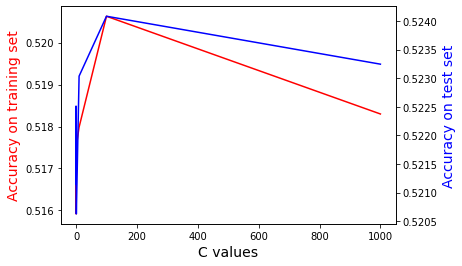

In [18]:
# We plot the results
fig,ax = plt.subplots()
ax.plot(C_values, Accuracy_training_logreg, color="red")
ax.set_xlabel("C values",fontsize=14)
ax.set_ylabel("Accuracy on training set",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(C_values, Accuracy_test_logreg,color="blue")
ax2.set_ylabel("Accuracy on test set",color="blue",fontsize=14)
plt.show()

As show in the graph and in the results, we obtain an accuracy on test set of ~ 0.52 with C = 100, so we will take this parameter as reference for logistic regression.

### Decision Trees Analysis
For **Decision Trees** model we have to control the complexity of the model, for that purpose we will do a *pre-prunning* determining the a maximum depth where the model will stop the creation of the tree.

In [19]:
# Preprunning for decision tree model, avoiding overfitting
depths = range(3,15)
Accuracy_training_tree = [] * len(depths)
Accuracy_test_tree = [] * len(depths)
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_f1_in = f1_score(y_train, prediction_in, average="weighted")
    prediction_out = tree.predict(X_test)
    accuracy_f1_out = f1_score(y_test, prediction_out, average="weighted")
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 30)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )
    Accuracy_training_tree.append(tree.score(X_train, y_train))
    Accuracy_test_tree.append(tree.score(X_test, y_test))


Decision tree with depth  3
------------------------------
Accuracy on training set:  0.49856020942408374 	f1 training set:  0.43092413748837455
Accuracy on test set:  0.4918324607329843 	f1 test set:  0.42533642891605755

Decision tree with depth  4
------------------------------
Accuracy on training set:  0.5208638743455497 	f1 training set:  0.48503329697133185
Accuracy on test set:  0.5128795811518324 	f1 test set:  0.478604449126395

Decision tree with depth  5
------------------------------
Accuracy on training set:  0.5343717277486911 	f1 training set:  0.5287421229664375
Accuracy on test set:  0.5260732984293194 	f1 test set:  0.5202462282468803

Decision tree with depth  6
------------------------------
Accuracy on training set:  0.5397905759162304 	f1 training set:  0.5233333899454297
Accuracy on test set:  0.5306806282722513 	f1 test set:  0.5153676637641463

Decision tree with depth  7
------------------------------
Accuracy on training set:  0.5524607329842932 	f1 trainin

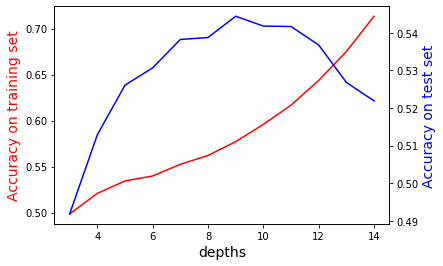

In [20]:
# We plot the results
fig,ax = plt.subplots()
ax.plot(depths, Accuracy_training_tree, color="red")
ax.set_xlabel("depths",fontsize=14)
ax.set_ylabel("Accuracy on training set",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(depths, Accuracy_test_tree,color="blue")
ax2.set_ylabel("Accuracy on test set",color="blue",fontsize=14)
plt.show()

As shown in the previous plot, is essential controlling the complexity of the model to avoid overfitting. In fact, for high values of depth is a clearly overfitting on the model. 
Then, we will take depth = 11 as parameter of reference for decision trees, where we are obtaining an accuracy on test set of ~ 0.54.

### Random Forest Analysis

For **Random Forests** we will set values of 2 parameters: number of trees and depth. Also, in order to avoid overfitting we decided to set *max_features* as the square of the number of features of our model.

In [21]:
# Random forest model
import numpy as np

n_trees = range(3,15)
Accuracy_training_forest = np.zeros((len(n_trees), len(depths)))
Accuracy_test_forest = np.zeros((len(n_trees), len(depths)))
j = 0

for trees in n_trees:
    i = 0
    for depth in depths:
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_f1_in = f1_score(y_train, prediction_in, average='weighted')
        prediction_out = random_forest.predict(X_test)
        accuracy_f1_out = f1_score(y_test, prediction_out, average='weighted')
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )
        Accuracy_training_forest[i][j] = random_forest.score(X_train, y_train)
        Accuracy_test_forest[i][j] = random_forest.score(X_test, y_test)
        i = i + 1
    j = j + 1
        


Random_forest with 3 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.5088219895287958 	f1 training set:  0.44887720042986184
Accuracy on test set:  0.4991623036649215 	f1 test set:  0.44082486339295107

Random_forest with 3 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.5309424083769634 	f1 training set:  0.5122157460152491
Accuracy on test set:  0.5190575916230367 	f1 test set:  0.5005688401795402

Random_forest with 3 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.5327748691099476 	f1 training set:  0.5027275786362475
Accuracy on test set:  0.5255497382198953 	f1 test set:  0.49834675505234605

Random_forest with 3 trees and 6 depth
----------------------------------------
Accuracy on training set:  0.5424083769633508 	f1 training set:  0.5194543334285948
Accuracy on test set:  0.5330890052356021 	f1 test set:  0.5100431820365402

Random_forest with 3 trees and 7

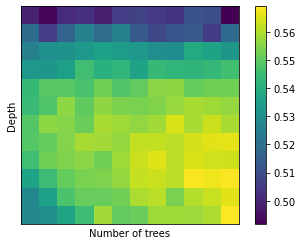

In [22]:
# In this case we are plotting 2 parameters, for that we make a colour graph
plt.imshow(Accuracy_test_forest)
plt.xlabel('Number of trees')
plt.ylabel('Depth')

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.grid(True)
plt.colorbar()
plt.show()

As we can see in this case we obtain an accuracy of 0.56 using 11 trees and depth 11.

### Model Results
As we can see, the best results are obtained for the following metrics (*accuracy on test set*): 
- Random Forest with 11 trees and 11 depth: accuracy of ~ 0.56.
- Logistic Regression with the parameter C = 100: accuracy of ~ 0.52.
- Decision Tree with deph 11: accuracy ~ 0.54.

Now we will decide which one to choose. 


Logistic Regression
--------------------
Accuracy on training set:  0.5175130890052356 	f1 training set:  0.4873177609036535
Accuracy on test set:  0.5201047120418848 	f1 test set:  0.4896246160890367

Decision Tree
--------------------
Accuracy on training set:  0.616675392670157 	f1 training set:  0.6063567183518522
Accuracy on test set:  0.5413612565445026 	f1 test set:  0.5312510244225257

Random Forest
--------------------
Accuracy on training set:  0.6492670157068062 	f1 training set:  0.634512310108459
Accuracy on test set:  0.5653403141361256 	f1 test set:  0.5471682132531527


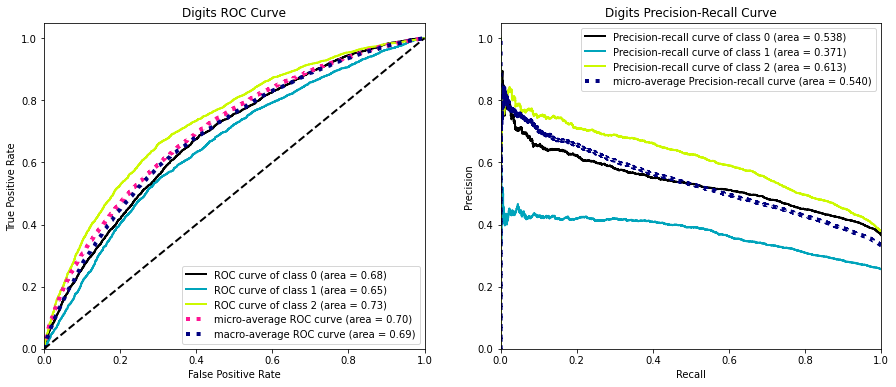

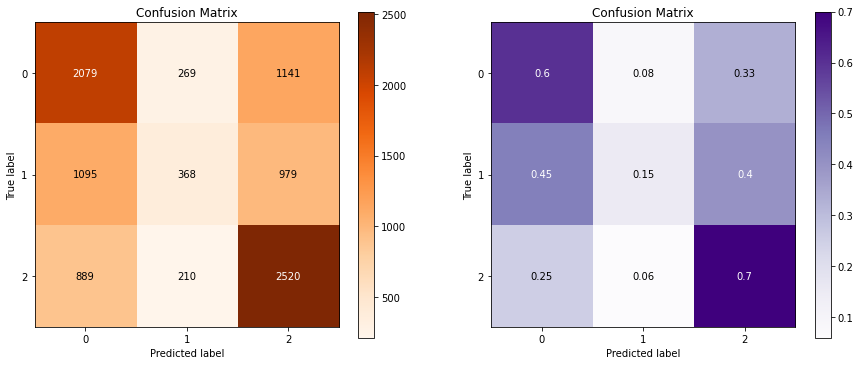

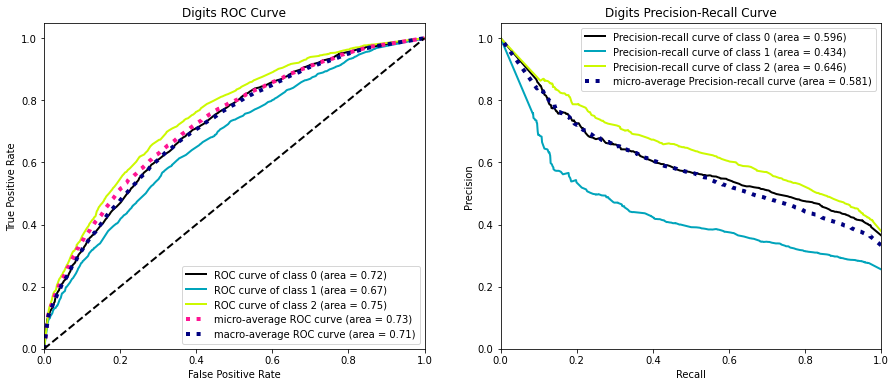

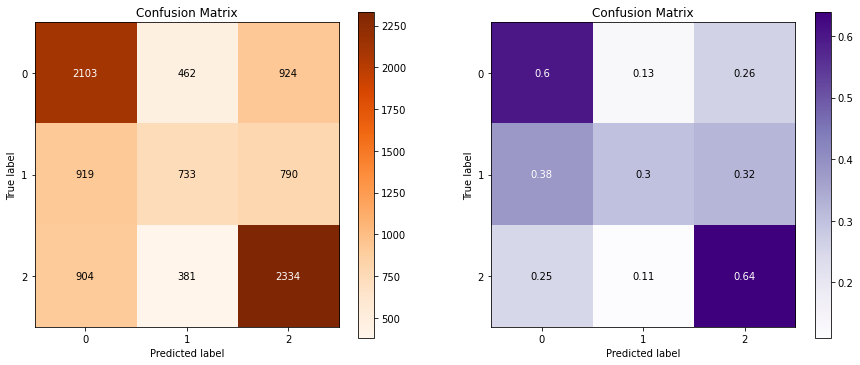

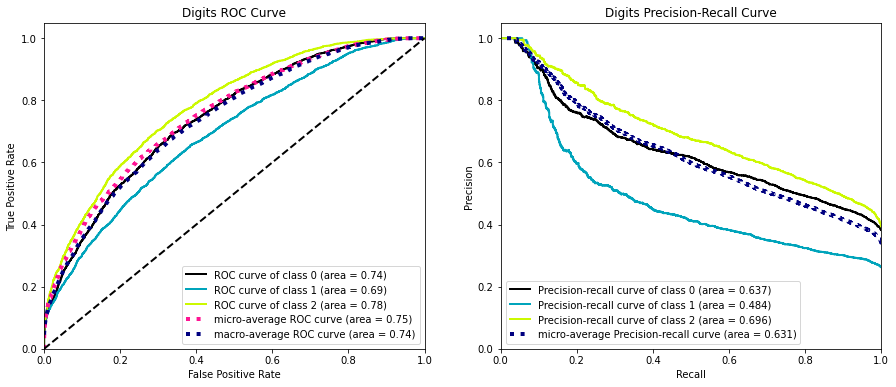

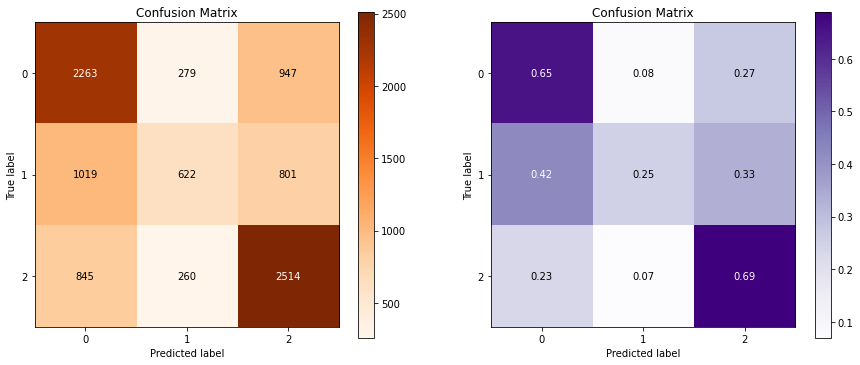

In [23]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]

classifiers = [
    LogisticRegression(solver='sag', multi_class='auto', max_iter=1000, C=100),
    DecisionTreeClassifier(max_depth=11),
    RandomForestClassifier(max_depth=11, n_estimators=11, max_features=3),
]

for name, clf in zip(names, classifiers):
        model = clf.fit(X_train, y_train)
        prediction_in = model.predict(X_train)
        accuracy_f1_in = f1_score(y_train, prediction_in, average='weighted')
        prediction_out = model.predict(X_test)
        accuracy_f1_out = f1_score(y_test, prediction_out, average='weighted')
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",model.score(X_train, y_train), "\tf1 training set: ", accuracy_f1_in )
        print("Accuracy on test set: ",model.score(X_test, y_test), "\tf1 test set: ", accuracy_f1_out )
        ROC_PRC_matrix(model, y_test, X_test)
        confusion_matrix(model, y_test, X_test)


## Selected Best Model: 
- Random Forest with 11 trees and 11 depth: accuracy of ~ 0.56.

## Model analysis, features importance

<AxesSubplot:>

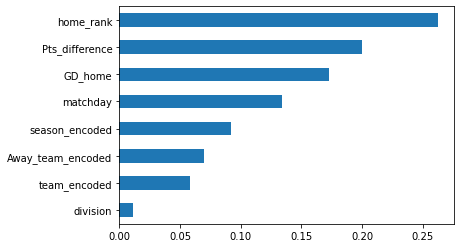

In [24]:
tree = RandomForestClassifier(max_depth=11, n_estimators=11, max_features=3).fit(X_train, y_train)
importances = pd.Series(tree.feature_importances_, index=dataset.columns[dataset.columns != 'result_home_encoded'] )
importances.sort_values(ascending=True).plot(kind="barh")